In [83]:
import nibabel as nib
import numpy as np
from sklearn.linear_model import Lasso,LassoCV,LinearRegression,Ridge
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor

from orelmisc import n_max,n_test_max,testpre,trainpre,saveCSV,y_org,shape_3d_org
from preprocess import flatten,flatten_each_sample,loadData,flatten_each_sample,precompute_and_save

In [84]:
prep = lambda i: i # int(i)
# don't round to the nearest integer anymore.
# it seems we can submit floating-point age xD HAHA... ... I should have tried this out before...
# ... But it seems that itdoesn't actually affect the score ... (changes in 0.05...)

x_org = None
x_t_org = None
xa_org = None
d_org = None
y = y_org
y_t_pred = None
y_t_pp = None
y_best = [57.072463768115945, 72.951219512195124, 53.678571428571431, 81.222222222222229, 80.125, 72.854166666666671, 50.92307692307692, 55.825581395348834, 68.902439024390247, 54.5625, 25.549019607843139, 54.200000000000003, 70.25, 32.07692307692308, 27.103896103896105, 69.384615384615387, 26.18, 76.625, 84.225806451612897, 82.470588235294116, 78.0, 27.058823529411764, 69.384615384615387, 82.068965517241381, 71.807692307692307, 40.660377358490564, 71.65384615384616, 24.805555555555557, 28.443037974683545, 32.288888888888891, 73.333333333333329, 33.708333333333336, 25.325301204819276, 25.897435897435898, 27.611111111111111, 58.109090909090909, 82.074074074074076, 82.681818181818187, 62.857142857142854, 79.956521739130437, 41.353741496598637, 72.962962962962962, 83.1875, 31.595890410958905, 65.130434782608702, 62.25925925925926, 44.960000000000001, 28.357798165137616, 28.752688172043012, 58.805555555555557, 27.868131868131869, 75.966666666666669, 25.222222222222221, 52.314285714285717, 32.272727272727273, 85.150000000000006, 75.023255813953483, 77.736842105263165, 26.303797468354432, 50.737499999999997, 65.871794871794876, 74.309090909090912, 47.92307692307692, 57.125, 27.600000000000001, 38.049999999999997, 27.09090909090909, 35.0, 78.782608695652172, 83.0, 79.155555555555551, 76.806451612903231, 25.159574468085108, 25.141025641025642, 72.854166666666671, 72.142857142857139, 50.727272727272727, 58.615384615384613, 71.765957446808514, 29.516129032258064, 67.51428571428572, 76.770833333333329, 85.909090909090907, 31.358490566037737, 29.013333333333332, 82.5, 25.965116279069768, 42.642857142857146, 29.300000000000001, 76.21621621621621, 25.794117647058822, 71.599999999999994, 49.848837209302324, 25.986111111111111, 71.65384615384616, 85.878787878787875, 70.888888888888886, 74.304347826086953, 65.666666666666671, 57.100000000000001, 53.663265306122447, 47.416666666666664, 50.704081632653065, 79.583333333333329, 27.207999999999998, 28.899999999999999, 79.666666666666671, 30.283950617283949, 28.065789473684209, 61.5, 30.782608695652176, 29.06451612903226, 25.847457627118644, 67.0, 81.78947368421052, 29.352517985611509, 76.0, 69.10526315789474, 38.410714285714285, 30.419354838709676, 30.049180327868854, 26.615384615384617, 40.588785046728972, 34.328125, 69.319148936170208, 28.329113924050635, 48.043478260869563, 51.761904761904759, 26.100000000000001, 82.950000000000003, 25.743243243243242, 45.153153153153156, 25.549019607843139, 27.5390625, 25.710280373831775, 24.865853658536587, 83.142857142857139, 79.646341463414629]
prefix=None
alpha = 10
result = None
xa = []
x = None
x_t = None

In [85]:
space = 200 # 200 # 50 is smooth, 200 is a bit more noisy

name = "output/mean_var_mean_std_hist"+str(space)+"_adaboosting"
#fname = "ax_1_2_3_avg_var.npy"
#fname = "mean_std_loghist_scale2.npy"
#fname = "mean_std_hist120_scale1.npy"
#fname = "mean_std_hist500_scale1.npy"
fname = "statistics_diff_hist" + str(space) + ".npy"
fnameMeanHist = "mean_hist" + str(space) + ".npy"

xa = np.load(fname)
x = xa[0:n_max,:]
x_t = xa[n_max:,:]
nPercentiles = 20
bStat = 7
bins = np.linspace(1,1900,space)
sbins = bins[:-1]+(bins[1]-bins[0])/2.0#bins used to plot the data
ds = bStat + nPercentiles + space-1 # sum,sum2,sum3,avg,var,mode, numper of percentiles and histogram
iHist = bStat + nPercentiles
# doStuff(al=870,n_est=900) # BEST ONE!!!!!!!

In [86]:
def myloop(a):
    return (a,a*a,a*a*a)

myloopU = np.frompyfunc(myloop,1,3,dtype=np.float64)

def loadAndPreprocess():
    global d_org,x,x_t,xa,x_org,x_t_org,xa_org
    
    d_org = 6443008
    """if x_org == None:
        x_org = loadData(scale=1,train=True)
        x_t_org = loadData(scale=1,train=False)
        d_org = 88*88*104# 6443008

        xa_org = np.zeros((n_max+n_test_max,d_org))
        xa_org[0:n_max] = x_org
        xa_org[n_max:] = x_t_org
        #xa = np.zeros((n_max+n_test_max,5+space-1))
    
    """
    xa = np.zeros((n_max+n_test_max,ds))
    hists = np.zeros((n_max+n_test_max,space-1))
    
    i = 0
    print "First loop. Calculate basic statistics and the absolute histogram"
    while i < n_max+n_test_max:
      if i % 5 == 0:
        print "Doing i = %s ..." % i
      
      n_i,pre,t_str = (n_max,"set_train/","train") if i < n_max else (n_test_max,"set_test/","test")
      filename = "%s%s_%s.nii" % (pre,t_str,i%n_max+1)
      data = nib.load(filename).get_data()
      #data=xa_org[i]
      sum = 0.0
      sum2 = 0.0
      sum3 = 0.0
      avg = 0.0
      var = 0.0
      data = data.ravel()
      res = myloopU(data)
      sum = np.sum(res[0])
      sum2 = np.sum(res[1])
      sum3 = np.sum(res[2])
      avg = sum / float(d_org)
      var = sum2 / float(d_org-1) - avg*avg
      hist = np.histogram(data,bins=bins)[0]
      percentiles = np.linspace(0,100,nPercentiles)
      iMax,hMax = max(enumerate(hist),key=lambda x:x[1])
      percs = np.percentile(hist,percentiles)
      xa[i,:bStat] = [sum,sqrt(sum2),pow(sum3,1/3.0),avg,var,iMax,hMax]
      xa[i,bStat:iHist] = percs
      hists[i] = hist
      i = i+1
    
    meanHist = np.mean(hists[:n_max,:],axis=0)
    
    np.save(fnameMeanHist,meanHist)
    print "Saved mean hist into into %s" % fnameMeanHist
    
    print "Second loop. Compute differences to mean-hisgtogram and save matrix"
    i = 0
    while i < n_max+n_test_max:
      xa[i,(bStat+nPercentiles):] = hists[i]-meanHist
      i=i+1
    
    np.save(fname,xa)
    print "Saved into %s" % fname
    x = xa[0:n_max]
    x_t=xa[n_max:]

## SCHLUSSFOLGERUNG: brauche ein isschen mehr sachen als nur diese momente und summen.
# vielleicht ein grobes histogram?
# pures Lasso und SVD+Lasso waren am besten... mit RSS 155...

## SCLUSSFOLGERUNG 2:
# Pures Lasso mit alpha = 750 war gut. RSS 84 ..
# SVD auf das Histogram bringt keinen Mehrwert...
# Das Ergebnis wrde allein durch die Momente und Statistischen Werte erreicht!!
# [sum,sum2,sum2,avg,var]

# SCHLUSSFOLGERUNG 3:
# Pures Lasso auf den statistischen daten und dem histogram. Mit alpha = 870 wurde bis zu RSS 77 erreicht!
# wir sind damit unter der öffentlichen Schranke von 80 angelangt!


# Schlussfolgerung 4:
# Ada
    # Lasso
    # Polynomial fitting
    # Default Desicion Tree Estimator was good!!! -> RSS 70

In [87]:
#print y
#loadAndPreprocess()

In [88]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def makeGaussianProcess():
  global y_t_pred,resulty
  prefix = "%s_GPs_FULL"%(name)
  kernel = RBF(1e5,(1e-4,1e15))
  model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9)
  y_t_pred = model.fit(x[:,:5],y).predict(x_t[:,:5])
  r = model.score(x[:,:5],y)
  print("score r = %s"%r)
  print "Coefficients: %s" % model.get_params()
  return prefix,model

def makeSVDLassoPrediction(comps,al=15):
  global y_t_pred,result,alpha
  alpha = al
  svd = TruncatedSVD(n_components=comps,n_iter=20)
  print "Prediction with alpha = %s" % alpha
  prefix = "%sSVD_Lasso_comps%s_alpha%s_FULL"%(name,comps,alpha)
  #x1 = np.concatenate((x[:,:5],svd.fit_transform(x)),axis=1)
  #x1 = svd.fit_transform(x)
  #x_t1 = svd.transform(x_t)
  #x_t1 = np.concatenate((x_t[:,:5],svd.transform(x_t)),axis=1)
   
  #x1 = x[:,iHist:]; x_t1 = x_t[:,iHist:]
  #x1 = x[:,:iHist]; x_t1 = x_t[:,:iHist]
  x1 = x[:,:]; x_t1 = x_t[:,:] 

  lasso = Lasso(alpha=alpha)
  y_t_pred = lasso.fit(x1,y).predict(x_t1)
  r = lasso.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  print "Coefficients: %s...." % lasso.coef_[:5]
  #print "singular values of x0: %s" % np.sort(x1[0])
  plt.clf()
  plt.plot(np.sort(x1[0]))
  plt.show()
  return prefix,lasso
       
def makeAdaDefaultBaseEstimatorPrediction(n_est):
  global y_t_pred,result
  print "Prediction and #estimators = %s" % (n_est)
  prefix = "%s_AdaBoost_n_est%s_DefaultDecisionTree"%(name,n_est)
  model = AdaBoostRegressor(n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Estimator weights: %s..." % model.estimator_weights_
  bla1 = (sorted(enumerate(model.estimator_weights_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest est-weights: %s..." % bla1
  plt.clf()
  plt.plot(model.estimator_weights_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_est_weights.png")
  plt.show()
  return prefix,model

def makeBaggingBoostLassoPrediction(al,n_est):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s and #estimators = %s" % (alpha,n_est)
  prefix = "%s_AdaBoost_Lasso_alpha%s"%(name,alpha)
  model = AdaBoostRegressor(Lasso(alpha=alpha),n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Estimator weights: %s..." % model.estimator_weights_
  bla1 = (sorted(enumerate(model.estimator_weights_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest est-weights: %s..." % bla1
  plt.clf()
  plt.plot(model.estimator_weights_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_est_weights.png")
  plt.show()
  return prefix,model
    
def makeAdaLassoPrediction(al,n_est):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s and #estimators = %s" % (alpha,n_est)
  prefix = "%s_AdaBoost_Lasso_alpha%s"%(name,alpha)
  model = AdaBoostRegressor(Lasso(alpha=alpha),n_estimators=n_est)
  x1 = x[:,:] # use all data
  x_t1 = x_t[:,:] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Estimator weights: %s..." % model.estimator_weights_
  bla1 = (sorted(enumerate(model.estimator_weights_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest est-weights: %s..." % bla1
  plt.clf()
  plt.plot(model.estimator_weights_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_est_weights.png")
  plt.show()
  return prefix,model
    
def makeLassoPrediction(al):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s" % alpha
  prefix = "%s_LassoPure_alpha%s_FULL"%(name,alpha)
  model = Lasso(alpha=alpha)
  x1 = x[:,:iHist] # use all data
  x_t1 = x_t[:,:iHist] # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % model.intercept_
  print "Coefficients: %s..." % model.coef_[:5]
  bla1 = (sorted(enumerate(model.coef_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest coefficients: %s..." % bla1
  plt.clf()
  plt.plot(model.coef_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_coefficients.png")
  plt.show()
  return prefix,model

def makeLassoCVPrediction(cv=3):
  global y_t_pred,result
  print "Prediction with cv = %s" % 3
  prefix = "%s_LassoCV_FULL"%(name)
  lasso = LassoCV(cv=cv)
  y_t_pred = lasso.fit(x,y).predict(x_t)
  r = lasso.score(x,y)
  m_log_alphas = -np.log10(lasso.alphas_)
  plt.plot(m_log_alphas, lasso.mse_path_, ':')
  plt.show()
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  #print "Coefficients: %s" % lasso.coef_
  return prefix,lasso


def makeLinearRegression():
  global y_t_pred,result
  prefix = "%s_LinReg_FULL"%(name)
  linreg = LinearRegression()
  y_t_pred = linreg.fit(x,y).predict(x_t)
  r = linreg.score(x,y)
  print("score r = %s"%r)
  print "Intercept: %s" % linreg.intercept_
  print "Coefficients: %s" % linreg.coef_
  print "Residues: %s" % linreg.residues_
  return prefix,linreg

In [89]:
def doStuff(al=15,comps=n_max-1,kernel="rbf",n_est=120):
  global prefix,result
  #loadAndPreprocess()
  
  #prefix,model = makeLassoPrediction(al=al)
  prefix,model  = makeAdaDefaultBaseEstimatorPrediction(n_est=n_est)
  #prefix,model = makeAdaLassoPrediction(al=al,n_est=n_est)
  #prefix,model = makeSVDLassoPrediction(al=al,comps=comps)
  #prefix,model = makeLassoCVPrediction(cv=3)
  #prefix,model = makeLinearRegression()
  #prefix,model = makeRidgePrediction(al=al)
  #prefix,model = makeGaussianProcess()
  #prefix,model = make_KPCA_prediction(kernel=kernel,al=al)
  
  y_t_pp = savePrediction()
  
  visualize(y,y_t_pp,prefix)
  
  print " ========= x ========== \n%s\n" % x
  print " ========= y_t_pp ========== \n%s\n" % y_t_pp
  
  # retuns a colleciton of stuff to return
  print "Variables available in 'result'"
  result = (x,y,x_t,y_t_pred,y_t_pp,model)

def visualize(y,y_t_pp,prefix):
  """ Step 5: make histogram plot of age """
  # (because no visualization for flat data matrix...)
  plt.hist(y,color="black",rwidth=0.7)
  #plt.hist(y_pred,color="darkgreen",rwidth=0.5)
  plt.hist(y_t_pp,color="darkblue",rwidth=0.5)
  plt.legend(["ages given for X",
    #"ages predicted for X",
    "ages predicted for X_t"])
  plt.savefig(prefix + "_histogram_ages.png")
  plt.show()
  plt.clf()
  plt.plot(np.array(y_t_pp)-np.array(y_best),"bo")
  plt.savefig(prefix + "_diff_to_score_77.png")
  plt.show()
  plt.clf()
  plt.plot(sorted(y_t_pp),"bo")
  plt.savefig(prefix + "_sorted.png")
  print("Saved age diagrams as %s"%(prefix+"*.png"))
  plt.show()

def savePrediction():
    global y_t_pp
    y_t_pp = [prep(i) for i in y_t_pred]
    savedFilename = saveCSV(y_t_pp,prefix)
    print("Saved predictions into %s" % savedFilename)
    return y_t_pp

Prediction and #estimators = 1403
score r = 0.960214091972
Estimator weights: [ 1.65931517  1.5336696   1.38009088 ...,  1.47057733  1.30882514
  1.77802831]...
Abs-Val largest est-weights: [(422, 2.3200405262240724), (964, 2.2238521247226193), (388, 2.1726311834504086), (263, 2.13900099098506), (1364, 2.0930285445034538)]...


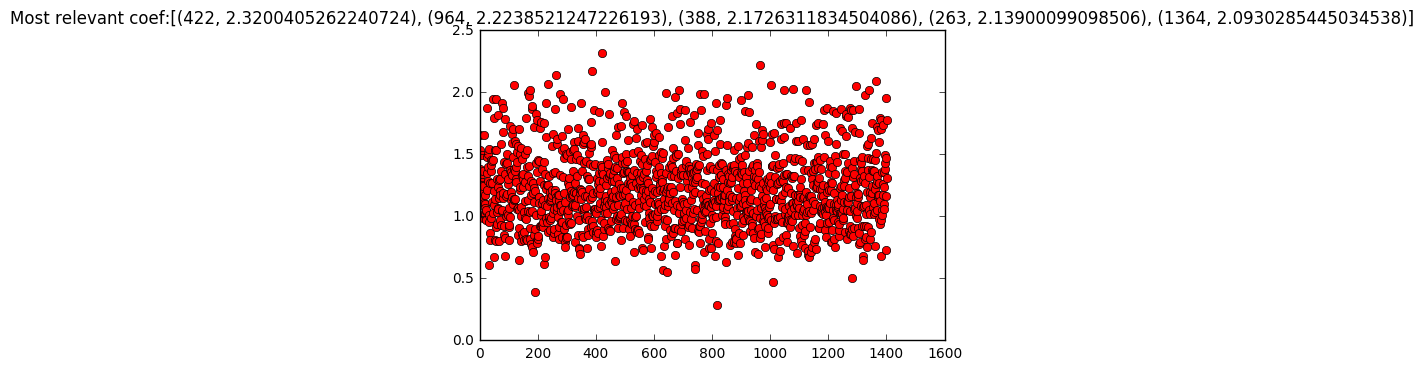

Saved predictions into output/mean_var_mean_std_hist200_adaboosting_AdaBoost_n_est1403_DefaultDecisionTree.csv


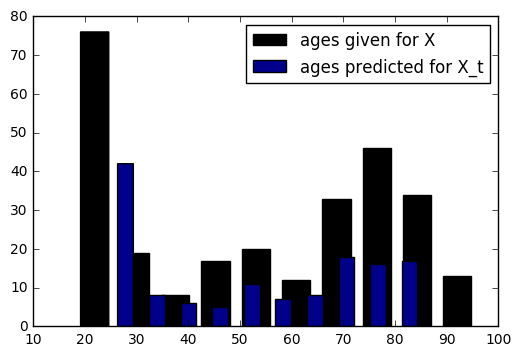

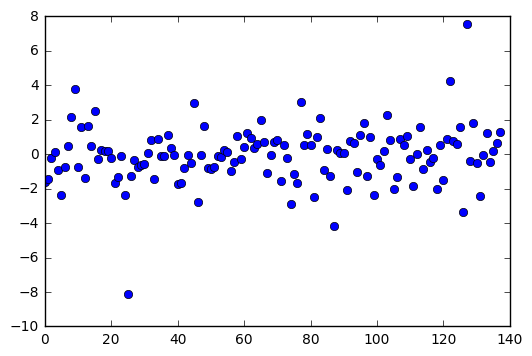

Saved age diagrams as output/mean_var_mean_std_hist200_adaboosting_AdaBoost_n_est1403_DefaultDecisionTree*.png


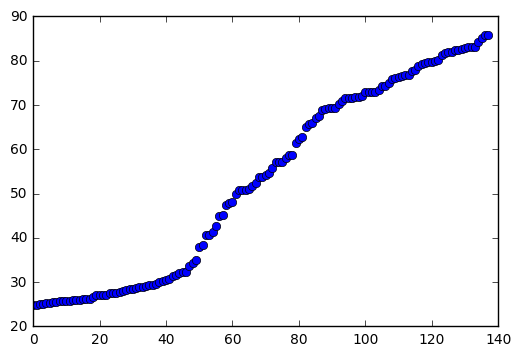

 ========= x ========== 
[[  1.50725930e+09   1.22970297e+06   1.17935264e+05 ...,   8.34532374e-01
   -4.70503597e+00   4.97122302e+00]
 [  1.51397922e+09   1.24338078e+06   1.19807807e+05 ...,  -2.16546763e+00
   -4.70503597e+00  -4.02877698e+00]
 [  1.52006085e+09   1.25454241e+06   1.20887034e+05 ...,   5.83453237e+00
    3.29496403e+00  -2.02877698e+00]
 ..., 
 [  1.52169988e+09   1.24241415e+06   1.19049472e+05 ...,  -1.16546763e+00
   -2.70503597e+00   4.97122302e+00]
 [  1.52123657e+09   1.25053893e+06   1.20567508e+05 ...,  -2.16546763e+00
    5.29496403e+00   4.97122302e+00]
 [  1.53099490e+09   1.25340495e+06   1.20335422e+05 ...,  -1.01654676e+01
   -1.07050360e+01  -1.00287770e+01]]

 ========= y_t_pp ========== 
[57.072463768115945, 72.951219512195124, 53.678571428571431, 81.222222222222229, 80.125, 72.854166666666671, 50.92307692307692, 55.825581395348834, 68.902439024390247, 54.5625, 25.549019607843139, 54.200000000000003, 70.25, 32.07692307692308, 27.103896103896105, 6

In [80]:
doStuff(n_est=1403)

## Histogram deviation from mean and Lasso coefficients

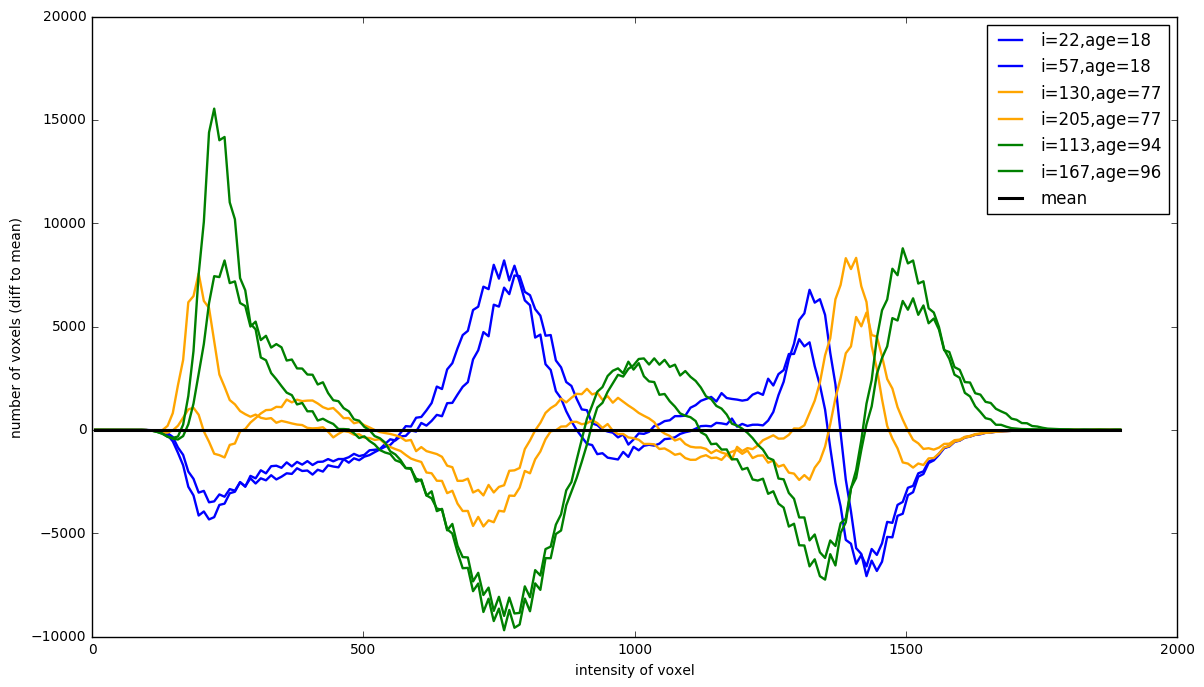

In [90]:
# show various histograms by age. revealing..
plt.clf()
g = "-adaboost-hist" + str(space)
fig = plt.figure(1)
fig.set_size_inches(14,8)
sortI = range(0,n_max)
sortI.sort(key=lambda i:y[i])
for si,i in enumerate(sortI[:2] + sortI[205:207] + sortI[-2:]):
    s = "i=%s,age=%s" % (i,y[i])
    c = "blue" if y[i] <= 25 else ("orange" if (23<= y[i] < 90) else "green")
    plt.plot(sbins,x[i,iHist:],label=s,color=c,linewidth=1.7)
plt.plot(sbins,x[0,iHist:]*0,label="mean",color="black",linewidth=2.2)
"""coeffs = result[5].coef_[0:]
coeffs_scaled = coeffs*pow(10,7.5) # scale for visibility
nonZero = [i for i in range(0,space-1) if coeffs[i]!=0]
print coeffs_scaled[nonZero]
plt.plot(bins[nonZero],coeffs_scaled[nonZero],"ro",
         label="lasso coefficients (non-zero)")
"""
plt.ylabel("number of voxels (diff to mean)")
plt.xlabel("intensity of voxel")
plt.legend(loc='upper right')
plt.savefig("gray-density-patients-by-age"+g+".png")
plt.show()

## Visualize all Histograms deviations per Age

i=22...
i=247...
i=1...
i=239...
i=53...
i=144...
i=97...
i=260...


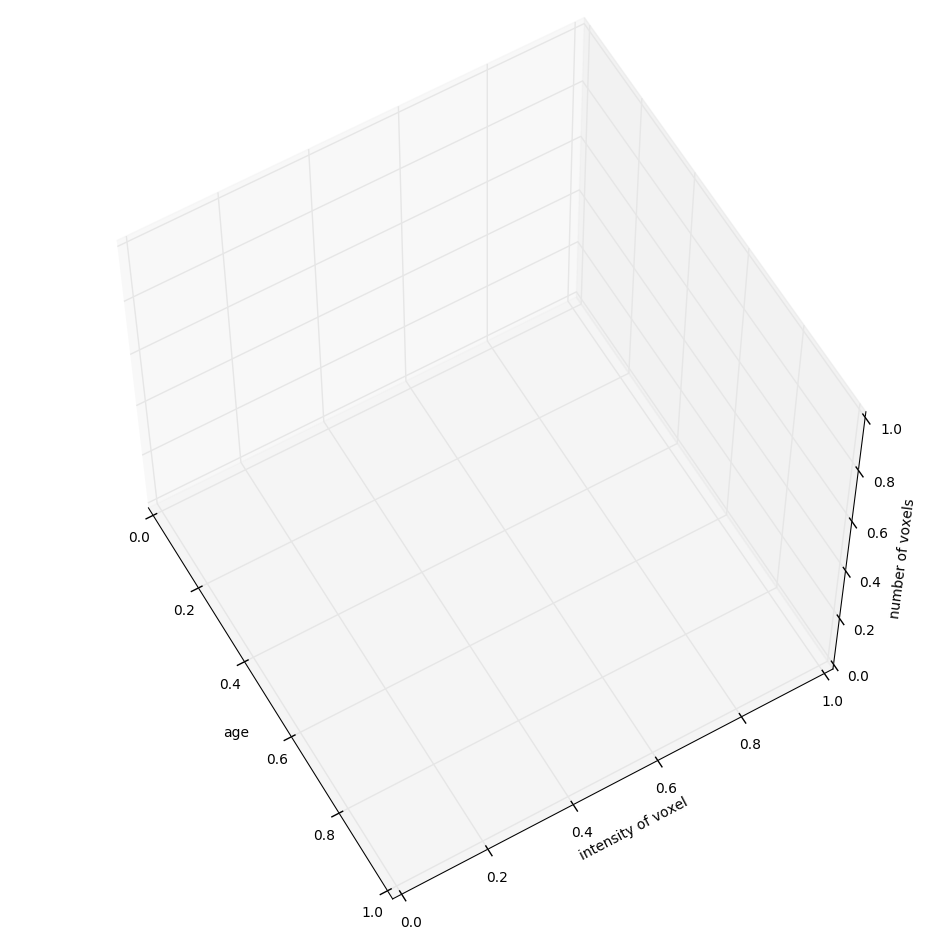

In [83]:
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt

plt.clf()
fig = plt.figure()
fig.set_size_inches(12,12)
ax = fig.gca(projection='3d')
tr = np.arange(0,len(bins))
maxZ = 8400
minZ = -7000
def zo(f):
    h = (f-minZ)/float(maxZ-minZ)
    e = float(4)
    g = max(min(h*e+(1-e)/2,1),0)
    return [g,0.6,1-g,0.5]
k = 50
for i in range(0,n_max,35):
    i=sortI[i]
    print "i=%s..."%i
    Z = x[i,5:]-df # Nvoxels
    Y = bins# intensity
    X = tr*0+y[i] # age
    for j in range(0,len(X)-k):
        ax.plot(X[j:j+k],Y[j:j+k],Z[j:j+k],linewidth=0.1,c=zo(Z[j+(k/2)]))
ax.set_xlabel("age")
ax.set_ylabel("intensity of voxel")
ax.set_zlabel("number of voxels")
ax.view_init(elev=60, azim=330)
#fig.savefig("all-histograms-by-age.png")
plt.show()